# Procedural elements

There are cases where you construct a logic out of a chain of primitive elements.
Take a gray counter, for example. It is used often for cross-clock-domain negotations
(dual clock FIFO fill counters).


## Gray counter

This gray counter example is a bit 'overdone' in comparison to the classical
examples to demonstrate configureability and procedural concatenation of elements.

### Gray 'primitive'

This `gray_unit` is a (configureable) element to construct gray counters of arbitrary length.

In [1]:
from myhdl import *

@block
def gray_unit(clk, ce, reset, defval, flavor, ia, ib, oa, ob):
    a = Signal(bool(defval))

    @always_seq(clk.posedge, reset)
    def worker():
        if ce == 1:
            a.next = a ^ ((ia ^ flavor) & ib)

    @always_comb
    def assign():
        oa.next = a
        ob.next = ib & ~(ia ^ flavor)

    return instances()

From this element, we construct a gray counter using a few auxiliaries:

In [2]:
def graycode(v, size):
    bv = intbv(v)[size:]
    z = bv ^ concat("0", bv[size:1])
    # print "Gray code:", z, len(bv)
    return intbv(z)[size:]

def parity(v):
    """Return parity bit from value v"""
    p = False
    for i in v:
        if i:
            p = ~p

    return p

@block
def gray_counter(clk, ce, reset, rval, direction, val, USE_ALIAS = False):
    n = len(val)
    p = parity(rval)
    z = not (p ^ direction)
    
    if USE_ALIAS:
        u = [ Signal(z), ]
        u += [ Signal(bool(0)) for i in range(n) ]
        # Make an alias for the parity toggle bit,
        # otherwise reset behaviour will be quirky
        u0 = u[0]
    else:
        u0 = Signal(z)
        # Use a reference in the array:
        u = [u0] + [ Signal(bool(0)) for i in range(n) ]

    v = [ Signal(bool()) for i in range(n+1) ]
    s = Signal(bool())

    out = ConcatSignal(*reversed(u))
    inst_gray = []

    @always_seq(clk.posedge, reset)
    def worker():
        if ce == 1:
            u0.next = not u0

    @always_comb
    def assign():
        val.next = out[:1]
        if direction == 1:
            s.next = u[n-1] ^ u[n]
        else:
            s.next = u[n-1] | u[n]
        v[0].next = True

    for i in range(1, n):
        inst_gray.append(gray_unit(clk, ce, reset, rval[i-1], direction, u[i-1], v[i-1], u[i], v[i]))

    # and MSB:
    inst_gray.append(gray_unit(clk, ce, reset, rval[n-1], direction, s, v[n-1], u[n], v[n]))

    return instances()



## Design

We instance a gray counter with `SIZE` bits:

In [3]:
from myhdl.conversion import yshelper

def create(SIZE, index):

    reset = ResetSignal(0, 1, isasync = False)
    ce = Signal(bool(0))
    clk = Signal(bool(0))
    ptr = Signal(intbv()[SIZE:])
    
    # Reset value:
    rval = graycode(index, SIZE)

    design = yshelper.Design("blinky")

    gc = gray_counter(clk, ce, reset, rval, 1, ptr)

    yshelper.DebugOutput.debug = False

    gc.convert("yosys_module", design)
    return design

design = create(4, 0)
design.finalize("top")

Legacy class rval
CREATE Module: 'gray_unit_0'
Adding module with name: gray_unit_1_1_1_c0_c1_1_1_1_1
CONVERT_RTL tree >>>>>> 'GRAY_COUNTER_GRAY_UNIT_0_WORKER' 
CONVERT_RTL tree >>>>>> 'GRAY_COUNTER_GRAY_UNIT_0_ASSIGN' 
DONE instancing submodules
CREATE Module: 'gray_unit_1'
CREATE Module: 'gray_unit_2'
CREATE Module: 'gray_unit_3'
CREATE Module: 'gray_counter'
Legacy class rval
Adding module with name: gray_counter_1_1_1_4_c1_4
Non-Signal member rval__min
Non-Signal member rval__max
Non-Signal member rval__val
Non-Signal member rval__nrbits
SIGNAL ARRAY 'u'
SIGNAL ARRAY 'v'
CONVERT_RTL tree >>>>>> 'GRAY_COUNTER_WORKER' 
CONVERT_RTL tree >>>>>> 'GRAY_COUNTER_ASSIGN' 
++++++++ gray_unit_0: gray_unit_1_1_1_c0_c1_1_1_1_1 (Module) ++++++++
++++++++ gray_unit_1: gray_unit_1_1_1_c0_c1_1_1_1_1 (Cell) ++++++++
++++++++ gray_unit_2: gray_unit_1_1_1_c0_c1_1_1_1_1 (Cell) ++++++++
++++++++ gray_unit_3: gray_unit_1_1_1_c0_c1_1_1_1_1 (Cell) ++++++++
DONE instancing submodules


## RTL Display

Generating RTL image...
Display...


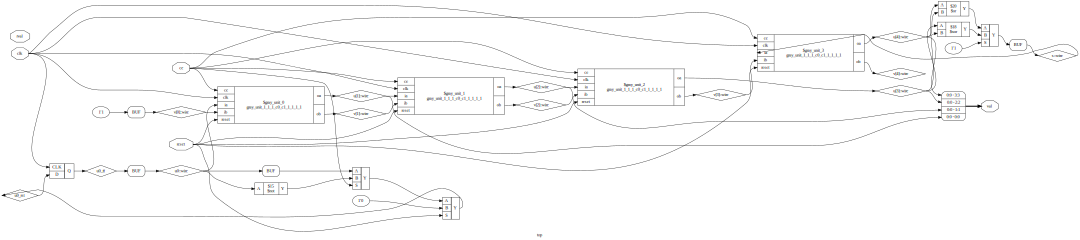

In [4]:
from ys_aux import to_svg

display(to_svg(design, "top", 150))

Display the `gray_unit`, explicitely:

Generating RTL image...
Display...


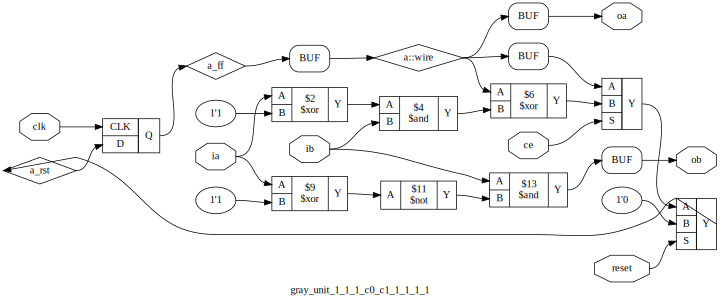

In [5]:
display(to_svg(design, 'gray_unit_1_1_1_c0_c1_1_1_1_1'))

## Simulation

In [6]:
from frequently_used import clkgen, lfsr8

def run_testbench(SIZE):
    # Declare the signals:    
    clk = Signal(bool())
    ce = Signal(bool())
    dout, debug = [ Signal(intbv()[SIZE:]) for i in range(2) ]
    reset = ResetSignal(0, 1, isasync = True)


    @block
    def tb_gray(clk, ce, reset, dout, debug):
        osc = clkgen(clk, 1)
        o = Signal(intbv()[SIZE:])    
        rv = graycode(4, SIZE)
        gc = gray_counter(clk, ce, reset, rv, 0, o)

        gc_single = [ Signal(bool()) for i in range(len(dout)) ]

        
        @always_comb
        def assign():
            dout.next = o
            for i in range(SIZE):
                gc_single[i].next = o[i]

        @instance
        def stim():
            ce.next = False
            reset.next = True
            yield delay(4)
            reset.next = False

            for v in [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1 ]:
                ce.next = v
                yield clk.negedge

            raise StopSimulation


        return instances()

    tb = tb_gray(clk, ce, reset, dout, debug)
    tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
    tb.run_sim()
    tb.quit_sim()

    
GRAY_COUNTER_SIZE = 5
run_testbench(GRAY_COUNTER_SIZE)

## Waveform display

In [7]:
import wavedraw
import nbwavedrom

TB = "tb_gray"

# Configure waveform:
cfg = { TB + '.reset' : None, TB + '.dout' : None, TB + '.ce' : None}

u = [ "tb_gray.gc_single.gc_single(%d)" % i for i in range(GRAY_COUNTER_SIZE) ]

for s in u:
    cfg[s] = None

waveform = wavedraw.vcd2wave("tb_gray.vcd", TB + '.clk', cfg)
    
nbwavedrom.draw(waveform)

### Observations

* The gray counter begins with a start value (`rval`) corresponding to an index
* Whenever `ce` is active, it advances according to the `direction` parameter
* Note that on every advance, only one bit flips in the counter output (`gc_single` bits)

### Exercices

* Change direction
* Try another start value